In [1]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u



plt.rcParams['pdf.fonttype']=42
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# load session
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
mouse = 'SparseKO_13'
d = sparse_sessions[mouse][6]
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']



pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls/', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)


In [11]:
sess.novel_arm


1

In [3]:
trial_masks = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}
# channel_0_mask = sess.trial_info['block_number']%2==0
left_mask = sess.trial_info['LR']==-1
print(sess.trial_info['LR'],left_mask)


# trial_masks['channel_0_left'] = channel_0_mask*left_mask
# trial_masks['channel_0_right'] = channel_0_mask*(~left_mask)
# trial_masks['channel_1_left'] = (~channel_0_mask)*left_mask
# trial_masks['channel_1_right'] = (~channel_0_mask)*(~left_mask)

trial_masks['channel_0_left'] = left_mask
trial_masks['channel_0_right'] = (~left_mask)
trial_masks['channel_1_left'] = left_mask
trial_masks['channel_1_right'] = (~left_mask)

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
  1. -1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1.] [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True

In [4]:
sess.place_cell_info['channel_1_F_dff']['right']['masks']

array([ True,  True,  True,  True, False, False, False, False, False,
        True, False,  True, False,  True,  True,  True, False, False,
       False, False,  True, False,  True,  True, False,  True,  True,
       False, False,  True, False, False,  True,  True,  True, False,
       False,  True,  True, False, False, False, False, False,  True,
       False, False, False,  True,  True, False,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False, False, False, False, False,  True,
       False,  True,  True, False, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False,  True,
       False, False,  True,  True,  True,  True, False, False, False,
       False,  True, False, False, False])

In [28]:
# pc mask

chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']

chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right

F = sess.timeseries['channel_1_spks']
F_chan1_mask = F[chan1_mask] 

F = sess.timeseries['channel_0_spks']
F_chan0_mask = F[chan0_mask]

In [4]:
def run_shuffle(F, trial_starts, teleports, t, rng):
    
    F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*F[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        F_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(F_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    return np.nanmean(tmat,axis=0)




In [30]:
# shuffle pc only 

rng = np.random.default_rng()

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}


F = F_chan0_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan0_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


F = F_chan1_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan1_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


In [6]:
sess.timeseries.keys()

dict_keys(['channel_0_F', 'channel_0_Fneu', 'channel_1_F', 'channel_1_Fneu', 'channel_0_F_dff', 'channel_0_spks', 'channel_1_F_dff', 'channel_1_spks', 'licks', 'speed', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt'])

In [5]:
# all cells

rng = np.random.default_rng()
nperms = 1000

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}

F = sess.timeseries['channel_0_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)

F = sess.timeseries['channel_0_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)


F = sess.timeseries['channel_1_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)

F = sess.timeseries['channel_1_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)


(1000, 30, 252)
(1000, 30, 252)
(1000, 30, 76)
(1000, 30, 76)


In [22]:
chan1_mask_pf_left

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
       False,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,

In [31]:
# pc only 

trial_means = {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_left'], : , :][...,chan0_mask_pf_left]),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_right'], : , :][...,chan0_mask_pf_right]),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_left'], : , :][...,chan1_mask_pf_left]),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_right'], : , :][...,chan1_mask_pf_right]),
              }

In [6]:
# all cells

trial_means = {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_right'], : , :], axis=0),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_right'], : , :],axis=0),
              }

In [7]:
trial_means

{'channel_0_left': array([[0.60494842, 0.81437263, 0.53549011, ..., 0.07836618, 0.02625004,
         0.0522942 ],
        [0.5510834 , 0.96736348, 0.49191568, ..., 0.09530121, 0.02281395,
         0.04639385],
        [0.47221947, 1.12003655, 0.41626562, ..., 0.10706213, 0.02034406,
         0.04089239],
        ...,
        [0.06371107, 0.06284305, 0.04129375, ..., 0.01878888, 0.03725394,
         0.05075006],
        [0.06262451, 0.05911469, 0.05079397, ..., 0.0166877 , 0.03786591,
         0.04845347],
        [0.06308342, 0.06273303, 0.06989887, ..., 0.01579397, 0.03378483,
         0.04117502]]),
 'channel_0_right': array([[0.09613743, 0.11102765, 0.77631802, ..., 0.03696192, 0.02950982,
         0.04221187],
        [0.08508038, 0.10964143, 0.74883524, ..., 0.04281896, 0.02892543,
         0.03900607],
        [0.07538555, 0.10784506, 0.67986407, ..., 0.05017234, 0.0289109 ,
         0.03746552],
        ...,
        [0.07685621, 0.07227346, 0.04803877, ..., 0.0218651 , 0.0265144

In [36]:
shuff_results = {}
shuff_results[mouse] = {}
shuff_results[mouse][0] = shuff_thresh

In [11]:
trial_means['channel_0_left'].shape


(30, 282)

In [33]:
shuff_thresh

{'channel_0_left': array([[0.00193668, 0.00585594, 0.00073183, ..., 0.00261801, 0.00338083,
         0.00159886],
        [0.00184028, 0.01048519, 0.00080811, ..., 0.00304635, 0.00417597,
         0.00200416],
        [0.00187166, 0.00834746, 0.00074361, ..., 0.00255053, 0.00360011,
         0.0019171 ],
        ...,
        [0.00200739, 0.01190332, 0.00404539, ..., 0.00230541, 0.00281012,
         0.00173137],
        [0.00197567, 0.0091917 , 0.00195185, ..., 0.00217645, 0.00354099,
         0.00157387],
        [0.00210958, 0.00087232, 0.00282074, ..., 0.00279267, 0.00440266,
         0.00281128]]),
 'channel_0_right': array([[0.00255496, 0.00168852, 0.00108001, ..., 0.00220831, 0.00301067,
         0.00324426],
        [0.00171884, 0.00173861, 0.00163314, ..., 0.001918  , 0.00292296,
         0.00249369],
        [0.00119541, 0.00267419, 0.00150684, ..., 0.00164487, 0.00308475,
         0.00245374],
        ...,
        [0.00211096, 0.00198457, 0.00079554, ..., 0.00306562, 0.0011959

In [39]:
def make_masks(sess):
    trial_masks = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}

    left_mask = sess.trial_info['LR']==-1
    print(sess.trial_info['LR'],left_mask)
    
    trial_masks['channel_0_left'] = left_mask
    trial_masks['channel_0_right'] = (~left_mask)
    trial_masks['channel_1_left'] = left_mask
    trial_masks['channel_1_right'] = (~left_mask)


    chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
    chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
    chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
    chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']
    
    chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
    chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right
    
    F = sess.timeseries['channel_1_spks']
    F_chan1_mask = F[chan1_mask] 
    
    F = sess.timeseries['channel_0_spks']
    F_chan0_mask = F[chan0_mask]

    return trial_masks, F_chan1_mask, F_chan1_mask

In [39]:
sess.trial_matrices.keys()

dict_keys(['channel_0_F_dff', 'bin_edges', 'bin_centers', 'channel_0_spks', 'channel_1_F_dff', 'channel_1_spks', 'licks', 'speed', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt'])

In [40]:
trial_means = {}
trial_means[mouse] = {}

In [41]:
trial_means[mouse][0]= {'channel_0_nov_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_fam_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_right'], : , :], axis=0),
               'channel_1_nov_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_fam_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_right'], : , :],axis=0),
              }

In [14]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice
sparse_mice[3:4]
shuff_results = {}
trial_means = {}

In [18]:


# sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)
for mouse in sparse_mice[3:4]:
    print(mouse)
    shuff_results[mouse] = {}
    trial_means[mouse] = {}
    for day in range(4,6):
        shuff_results[mouse][day] = {}
        trial_means[mouse][day] = {}

        sess = u.load_single_day(mouse, day)
        trial_masks, F_chan1_mask, F_chan1_mask = make_masks(sess)


        rng = np.random.default_rng()

        shuff_thresh = {'channel_0_left': None,
                       'channel_0_right': None,
                       'channel_1_left': None,
                       'channel_1_right': None}
        
        F = F_chan0_mask
        starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F = F_chan0_mask
        starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        F = F_chan1_mask
        starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F = F_chan1_mask
        starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

        shuff_results[mouse][day] = shuff_thresh # save to shuff_results

        if sess.novel_arm == -1:
            trial_means[mouse][day]= {'channel_0_nov_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_fam_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_right'], : , :], axis=0),
               'channel_1_nov_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_fam_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_right'], : , :],axis=0),
              }
        elif sess.novel_arm == 1:
            trial_means[mouse][day] = {'channel_0_fam_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_nov_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_right'], : , :], axis=0),
               'channel_1_fam_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_nov_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_right'], : , :],axis=0),
              }


SparseKO_13
{'date': '24_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 27, 'novel_arm': 1, 'exp_day': 1}
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.
 -1. -1. -1. -1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.
  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1.] [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  Tru

In [19]:
shuff_results.keys()

dict_keys(['SparseKO_13'])

In [70]:
import pickle 
with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_results.pkl','wb') as file:
        pickle.dump(shuff_results,file)

In [8]:
field_info = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}

for k, thresh in shuff_thresh.items():
    print(k, thresh.shape)
    sig_bins = trial_means[k]>thresh

    # eliminate fields that start at first bin of track or end at last bin of track
    

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        # print(_redge.size)
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0) and ((_redge[0][0]+_ledge[0])<29):
        # if (_redge.shape[0]>0):
        # if (_redge.shape[0]>0):
            field_info[k].append([_ledge[1], _ledge[0], _redge[0][0]])
        

            # fig, ax = plt.subplots()
            # ax.plot(trial_means[k][:,_ledge[1]
            # if 'channel_0' in k:
            #     ax.imshow(sess.trial_matrices['channel_0_F_dff'][trial_masks[k],:, _ledge[1]])
            #     ax.plot(_ledge[0]*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            #     ax.plot((_ledge[0]+_redge[0][0])*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            # else:
            #     ax.imshow(sess.trial_matrices['channel_1_F_dff'][trial_masks[k],:, _ledge[1]])
            #     ax.plot(_ledge[0]*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            #     ax.plot((_ledge[0]+_redge[0][0])*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            # print(trial_means[k].shape)
        # ax.imshow(trial_means[k][:,_ledge[1]])

for k,v in field_info.items():
    field_info[k]=np.array(v)

channel_0_left (30, 252)
channel_0_right (30, 252)
channel_1_left (30, 76)
channel_1_right (30, 76)


(array([0.79310345, 0.20689655, 0.        , 0.        ]),
 array([1., 2., 3., 4., 5.]),
 <BarContainer object of 4 artists>)

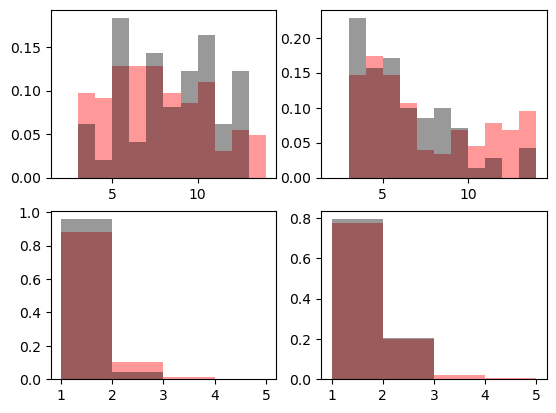

In [9]:
fig, ax = plt.subplots(2,2)

width_bins = np.arange(2,15)
field_bins = np.arange(1,6)
##
fi = field_info['channel_0_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)

##
fi = field_info['channel_1_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)

##
fi = field_info['channel_0_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)


##
fi = field_info['channel_1_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)


    

In [43]:
field_info['channel_0_left'].shape



(152, 3)